### Step 1: Construct circuit

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def QAOAPathCircuit(num_qubits: int, depth: int, 
                    barriers: bool = False, measurements: bool = False,
                   ):
    qaoa = QuantumCircuit(num_qubits)
    gammas = ParameterVector("γ", depth // 2)
    betas = ParameterVector("β", depth // 2)

    qaoa.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            qaoa.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            qaoa.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            qaoa.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            qaoa.rx(betas[layer], qubit)
    if measurements:
            qaoa.measure_all()

    return qaoa

In [26]:
num_qubits = 6
depth = 4

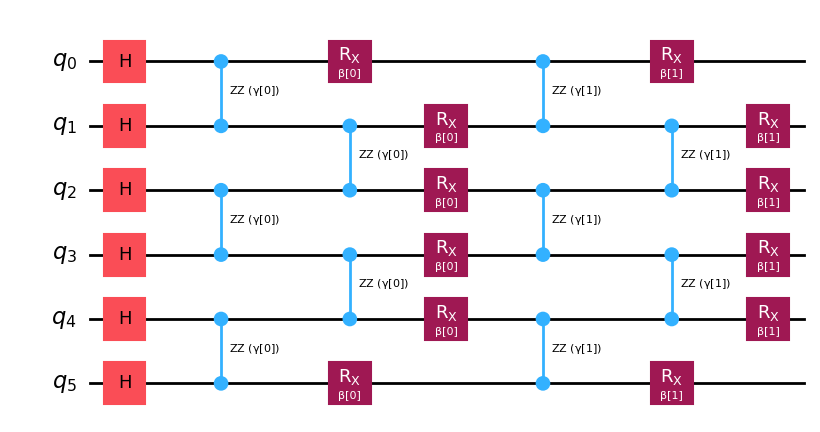

In [75]:
qaoa = QAOAPathCircuit(num_qubits, depth)
qaoa.draw('mpl')

#### Define parameters

In [28]:
from numpy.random import rand

parameters = rand(qaoa.num_parameters)
parameters

array([0.09045388, 0.86000425, 0.66048159, 0.96235352])

In [76]:
qaoa.assign_parameters(parameters, inplace=True)

### Step 2: Transpile and obtain isomorphic layouts

In [39]:
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
backend = FakeKolkataV2()

In [40]:
from qiskit import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=42)

isa_qaoa = pm.run(qaoa)

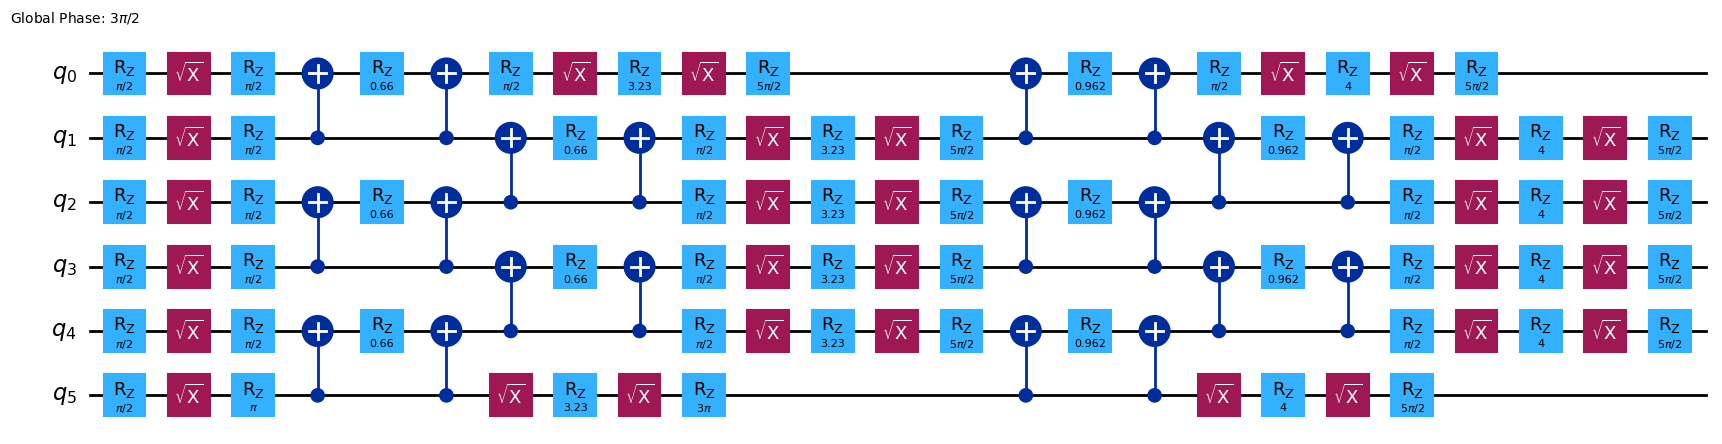

In [41]:
import mapomatic as mm

deflated_qaoa = mm.deflate_circuit(isa_qaoa)
deflated_qaoa.draw('mpl', fold=-1)

In [42]:
layouts = mm.matching_layouts(deflated_qaoa, backend)

In [43]:
len(layouts)

104

In [44]:
# for sanity check
scores = mm.evaluate_layouts(deflated_qaoa, layouts, backend)

Selecting the first 10 layouts, else too many circuit executions required. Note the first 10 layouts may not be the `best` 10 layouts.

In [45]:
layouts_to_use = layouts[:10]

### Step 3: Evaluate layouts using QIC

#### Construct QIC

In [46]:
from qic import QIC

qic = QIC([deflated_qaoa], gate_2q='cx')
qic_qaoa = qic.construct_qic()[0]

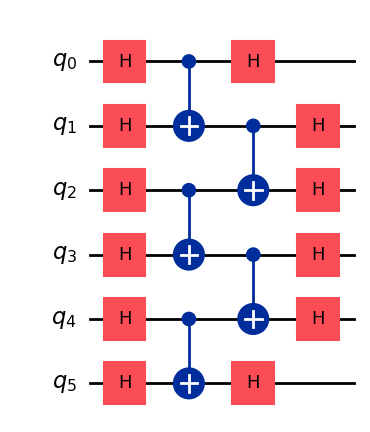

In [47]:
qic_qaoa.draw('mpl',fold=-1)

#### Define observable

In [48]:
from qiskit.quantum_info import SparsePauliOp

observables = []
for idx in range(qaoa.num_qubits):
    obs = 'I'*idx + 'Z' + 'I'*(qaoa.num_qubits-idx-1)
    observables.append(obs)

observables = SparsePauliOp(observables, coeffs=[1/len(observables)]*len(observables))
observables

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])

#### Transpile and define `pubs`

In [49]:
qic_pubs = []

for layout in layouts_to_use:
    qic_pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=layout, seed_transpiler=42)
    isa_qic = qic_pm.run(qic_qaoa)
    isa_obs = observables.apply_layout(isa_qic.layout)
    qic_pubs.append((isa_qic, isa_obs))

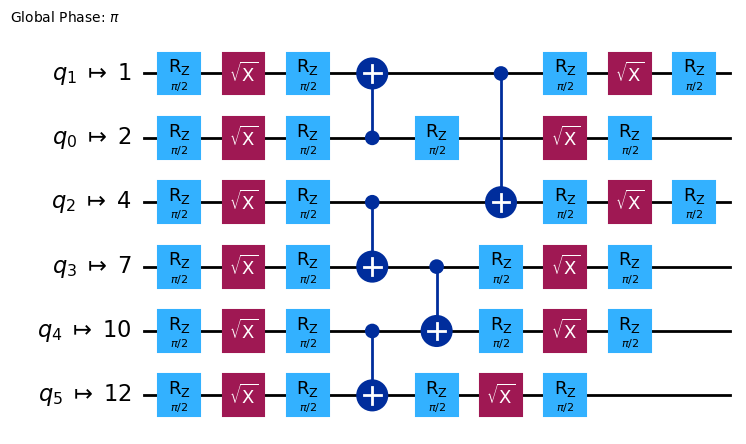

In [50]:
qic_pubs[0][0].draw('mpl', idle_wires=False)

In [64]:
estimator = EstimatorV2(mode=backend)
estimator.options.default_shots = 4000

qic_job = estimator.run(qic_pubs)
qic_result = qic_job.result()

In [65]:
qic_expvals = [round(float(qic_result[i].data.evs),3) for i in range(len(layouts_to_use))]
qic_expvals

[0.956, 0.958, 0.963, 0.951, 0.936, 0.965, 0.954, 0.95, 0.949, 0.955]

In [68]:
qic_scores = list(zip(layouts_to_use, qic_expvals))
qic_scores

[([2, 1, 4, 7, 10, 12], 0.956),
 ([4, 1, 2, 3, 5, 8], 0.958),
 ([0, 1, 2, 3, 5, 8], 0.963),
 ([0, 1, 4, 7, 10, 12], 0.951),
 ([1, 2, 3, 5, 8, 11], 0.936),
 ([1, 2, 3, 5, 8, 9], 0.965),
 ([3, 2, 1, 4, 7, 10], 0.954),
 ([3, 2, 1, 4, 7, 6], 0.95),
 ([1, 4, 7, 10, 12, 13], 0.949),
 ([1, 4, 7, 10, 12, 15], 0.955)]

In [69]:
# sort the qic_scores
qic_scores = sorted(qic_scores, key=lambda tup:tup[1], reverse=True)
qic_scores

[([1, 2, 3, 5, 8, 9], 0.965),
 ([0, 1, 2, 3, 5, 8], 0.963),
 ([4, 1, 2, 3, 5, 8], 0.958),
 ([2, 1, 4, 7, 10, 12], 0.956),
 ([1, 4, 7, 10, 12, 15], 0.955),
 ([3, 2, 1, 4, 7, 10], 0.954),
 ([0, 1, 4, 7, 10, 12], 0.951),
 ([3, 2, 1, 4, 7, 6], 0.95),
 ([1, 4, 7, 10, 12, 13], 0.949),
 ([1, 2, 3, 5, 8, 11], 0.936)]

### Step 4: Sanity check with mapomatic

In [70]:
best_qic_layout = qic_scores[0]
worst_qic_layout = qic_scores[-1]

In [71]:
# find the mapomatic scores of these layouts
for (layout, score) in scores:
    if layout == best_qic_layout[0]:
        best_mm_layout = (layout, score)
    if layout == worst_qic_layout[0]:
        worst_mm_layout = (layout, score)

In [72]:
print(best_mm_layout)
print(worst_mm_layout)

([1, 2, 3, 5, 8, 9], 0.14519933272086483)
([1, 2, 3, 5, 8, 11], 0.2484164640526796)


Note that QIC and Mapomatic DOES agree with each other as we see from this. Obviously it may not be monotonic if we take all the possible layouts since the score vary so little. But the trend will be there as was observed before.

### Step 5: Execute

For execution, I am using a mirrored circuit to avoid expectation values being too close to 0. Making the circuit mirrored guarantees that the ideal outcome of `Z` type expectation values is always +1. So we don't need ideal simulation as well.

P.S. We may need to think whether the reviewers will call out that both QIC (by design) and mirrored circuits have the same expval, hence it is working. So we should also show some examples where the ideal expval is not +1 (but also not very close to 0, which makes analysis difficult).

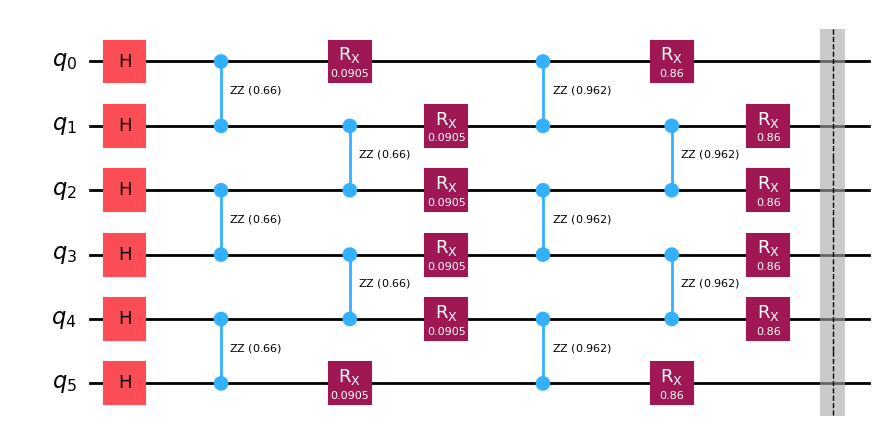

In [77]:
qaoa.barrier()
qaoa.draw('mpl')

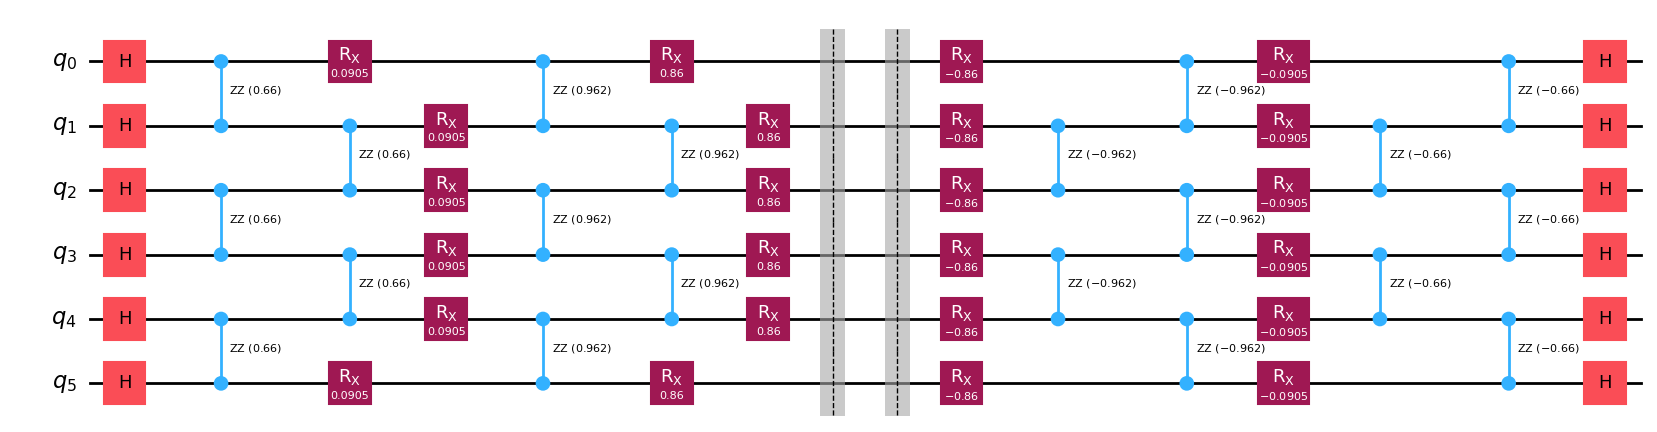

In [78]:
from qiskit.circuit.library import UnitaryOverlap

mirrored_qaoa = UnitaryOverlap(qaoa, qaoa)
mirrored_qaoa.draw('mpl', fold=-1)

In [85]:
pm_best = generate_preset_pass_manager(optimization_level=3, backend=backend, 
                                       initial_layout=best_qic_layout[0], seed_transpiler=42)
pm_worst = generate_preset_pass_manager(optimization_level=3, backend=backend, 
                                       initial_layout=worst_qic_layout[0], seed_transpiler=42)

isa_qaoa_best = pm_best.run(mirrored_qaoa)
isa_obs_best = observables.apply_layout(isa_qaoa_best.layout)

isa_qaoa_worst = pm_worst.run(mirrored_qaoa)
isa_obs_worst = observables.apply_layout(isa_qaoa_worst.layout)

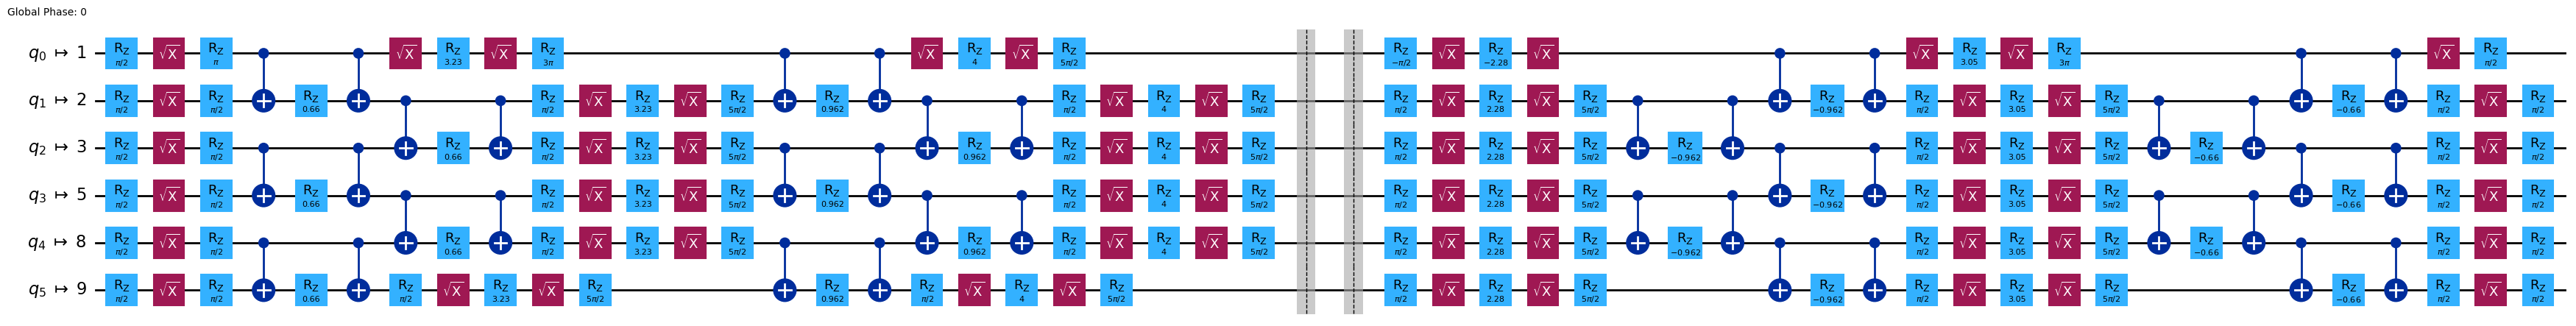

In [86]:
isa_qaoa_best.draw('mpl', fold=-1, idle_wires=False)

In [87]:
pubs = [(isa_qaoa_best, isa_obs_best), (isa_qaoa_worst, isa_obs_worst)]

In [88]:
job = estimator.run(pubs)
result = job.result()

In [89]:
print(f'Expval when executed on best QIC layout is {result[0].data.evs}')

Expval when executed on best QIC layout is 0.7979671748729484


In [91]:
print(f'Expval when executed on worst QIC layout is {result[1].data.evs}')

Expval when executed on worst QIC layout is 0.71765391985337
